In [179]:
import re
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer



from collections import Counter, defaultdict

In [2]:
df_credits = pd.read_csv('tmdb_5000_credits.csv')
df_movies = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
print('Movies shape', df_movies.shape)
print('Credits shape', df_credits.shape)

Movies shape (4803, 20)
Credits shape (4803, 4)


In [4]:
df_credits.head(3)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [5]:
df_movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


**convert json columns to string**

In [6]:
def json_to_string(df, col, key):
    df[col] = df[col].apply(json.loads)
    for indx, text in zip(df.index, df[col].values):
        val = []
        for j in text:
            val.append(j[key])
        df[col][indx] = val

In [7]:
json_to_string(df_movies, 'genres', 'name')
json_to_string(df_movies, 'keywords', 'name')
json_to_string(df_movies, 'production_companies', 'name')
json_to_string(df_movies, 'production_countries', 'name')
json_to_string(df_movies, 'spoken_languages', 'name')

<ipython-input-6-ad9e2ecfa6c1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][indx] = val


In [8]:
df_movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,Spectre,6.3,4466


In [9]:
def make_raiting_plot(column, name, size = 16):
    # create dictionary to count
    count_dict = defaultdict(int)
    for raw in column:
        for i in raw:
            count_dict[i] += 1

    # create two ordered lists
    item_list = []
    count_list = []
    for k, v in sorted(count_dict.items(), key=lambda x: x[1], reverse=True):
        item_list.append(k)
        count_list.append(v)

    # create plot
    color_map = ["#bdbdbd" for _ in range(size)]
    color_map[0] = color_map[1] = color_map[2] = "#008294"

    fig = plt.figure(figsize=(15, 7), dpi=300)

    plt.text(0, count_list[0]*1.1, name, fontsize=20,
             fontweight='bold', fontfamily='serif')
    plt.bar(item_list[:size], count_list[:size], color=color_map, zorder=3)
    plt.xticks(rotation=70)
    plt.ylabel('Number of films')
    plt.grid(color='black', linestyle=':', axis='y', zorder=0)
    plt.show()

## Genres column

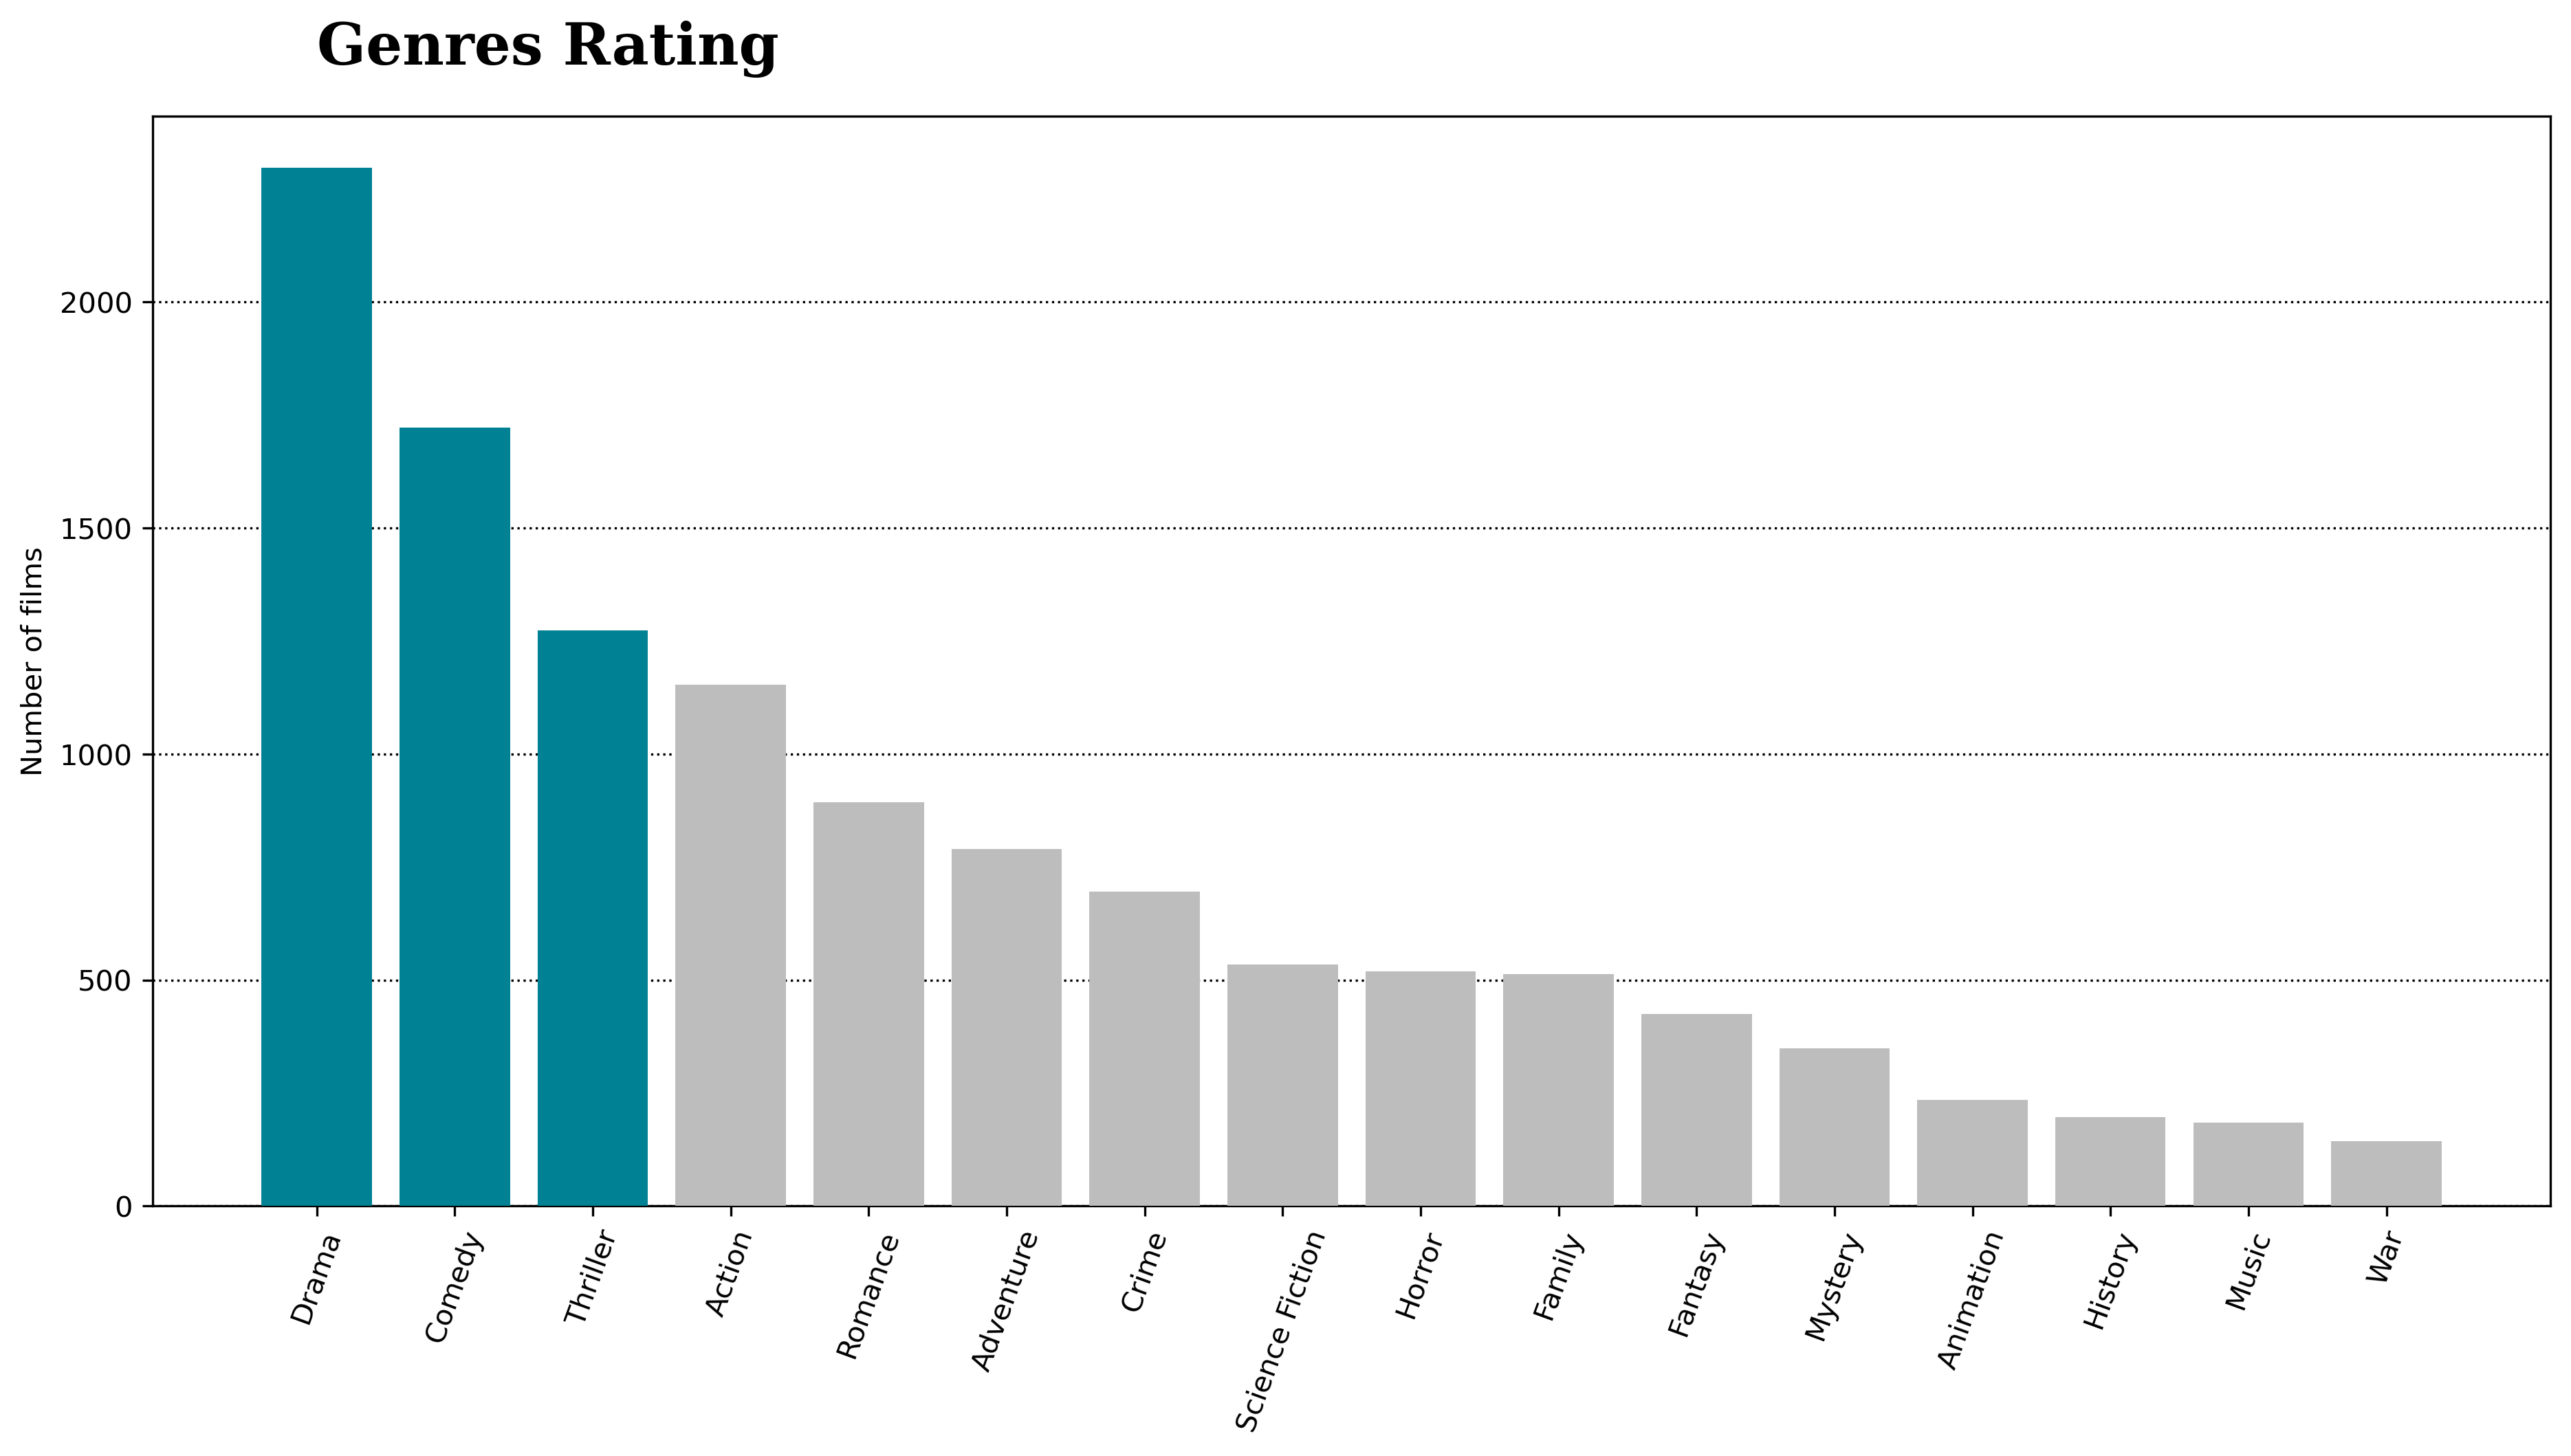

In [10]:
make_raiting_plot(df_movies['genres'], 'Genres Rating')

**Drama is the most popular genre in this movies collection. Comedy and thriller go after.**

## Production countries

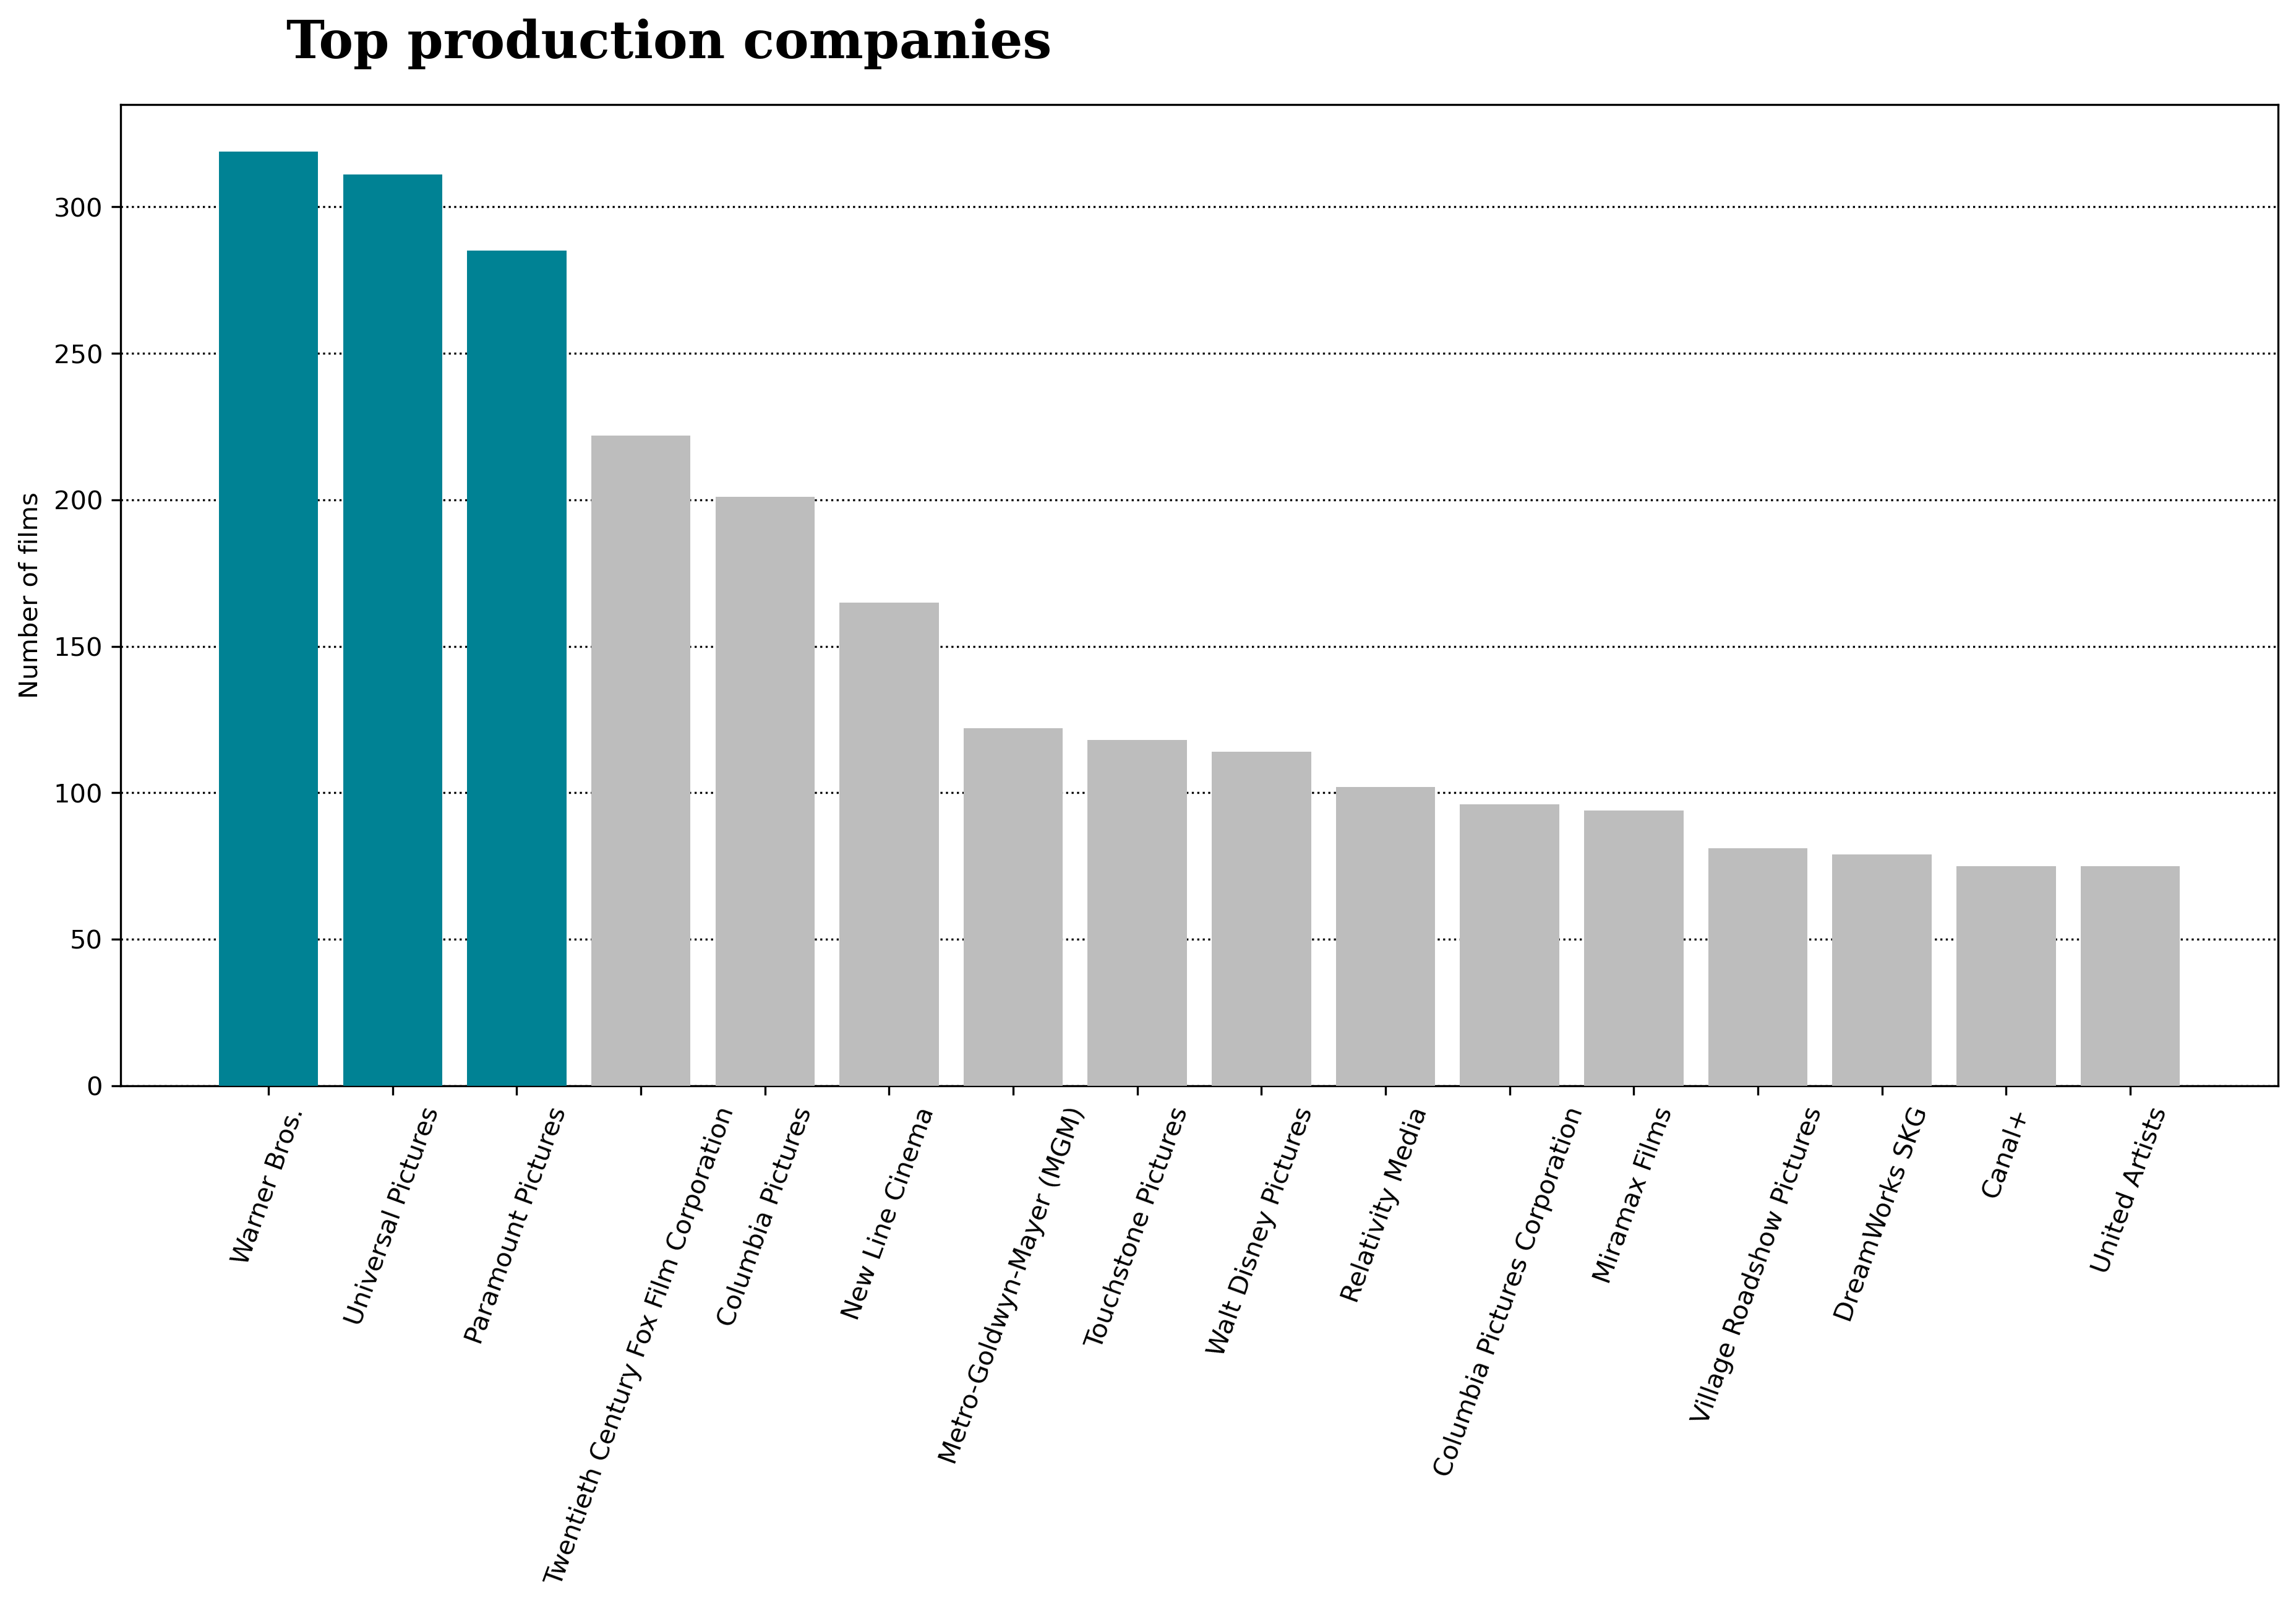

In [11]:
make_raiting_plot(df_movies['production_companies'], ' Top production companies')

**Three most popular companies are Warner Bros., Universal Pictures and Paramount Pictures**

## Prodiction countries

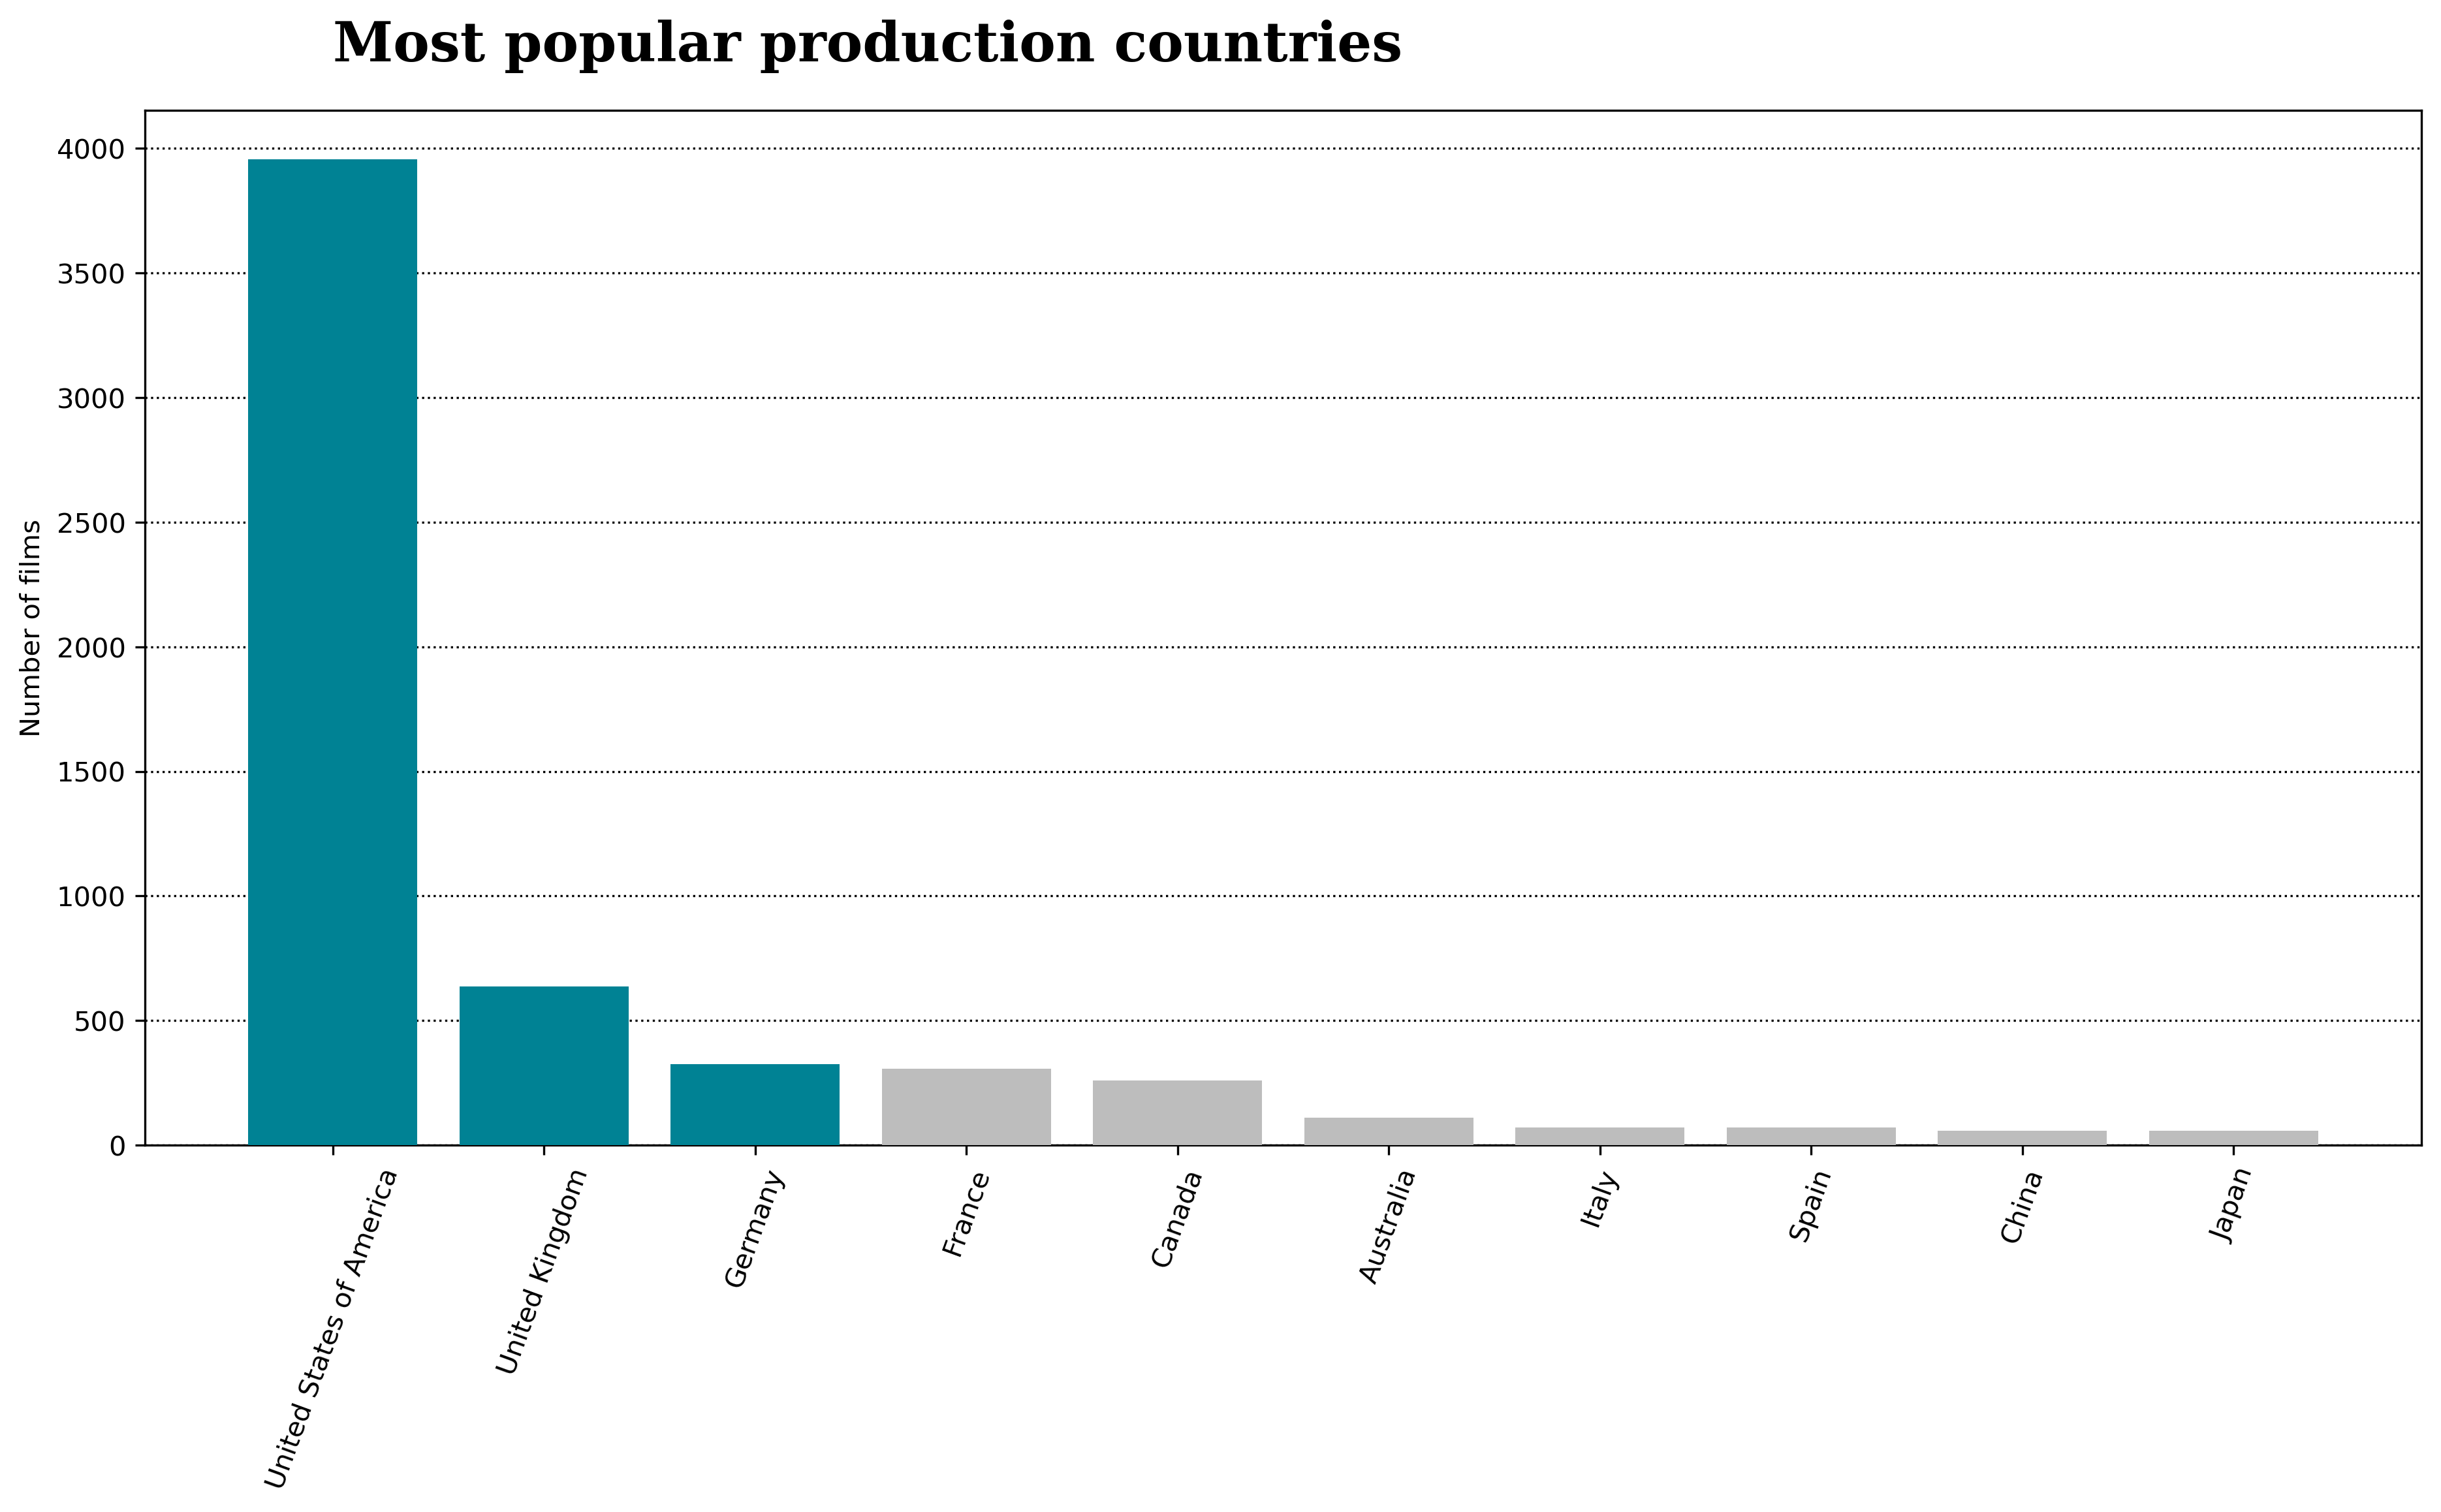

In [12]:
make_raiting_plot(df_movies['production_countries'], 'Most popular production countries', 10)

**United States of America is clear leader in this collection of movies**

## Keywords

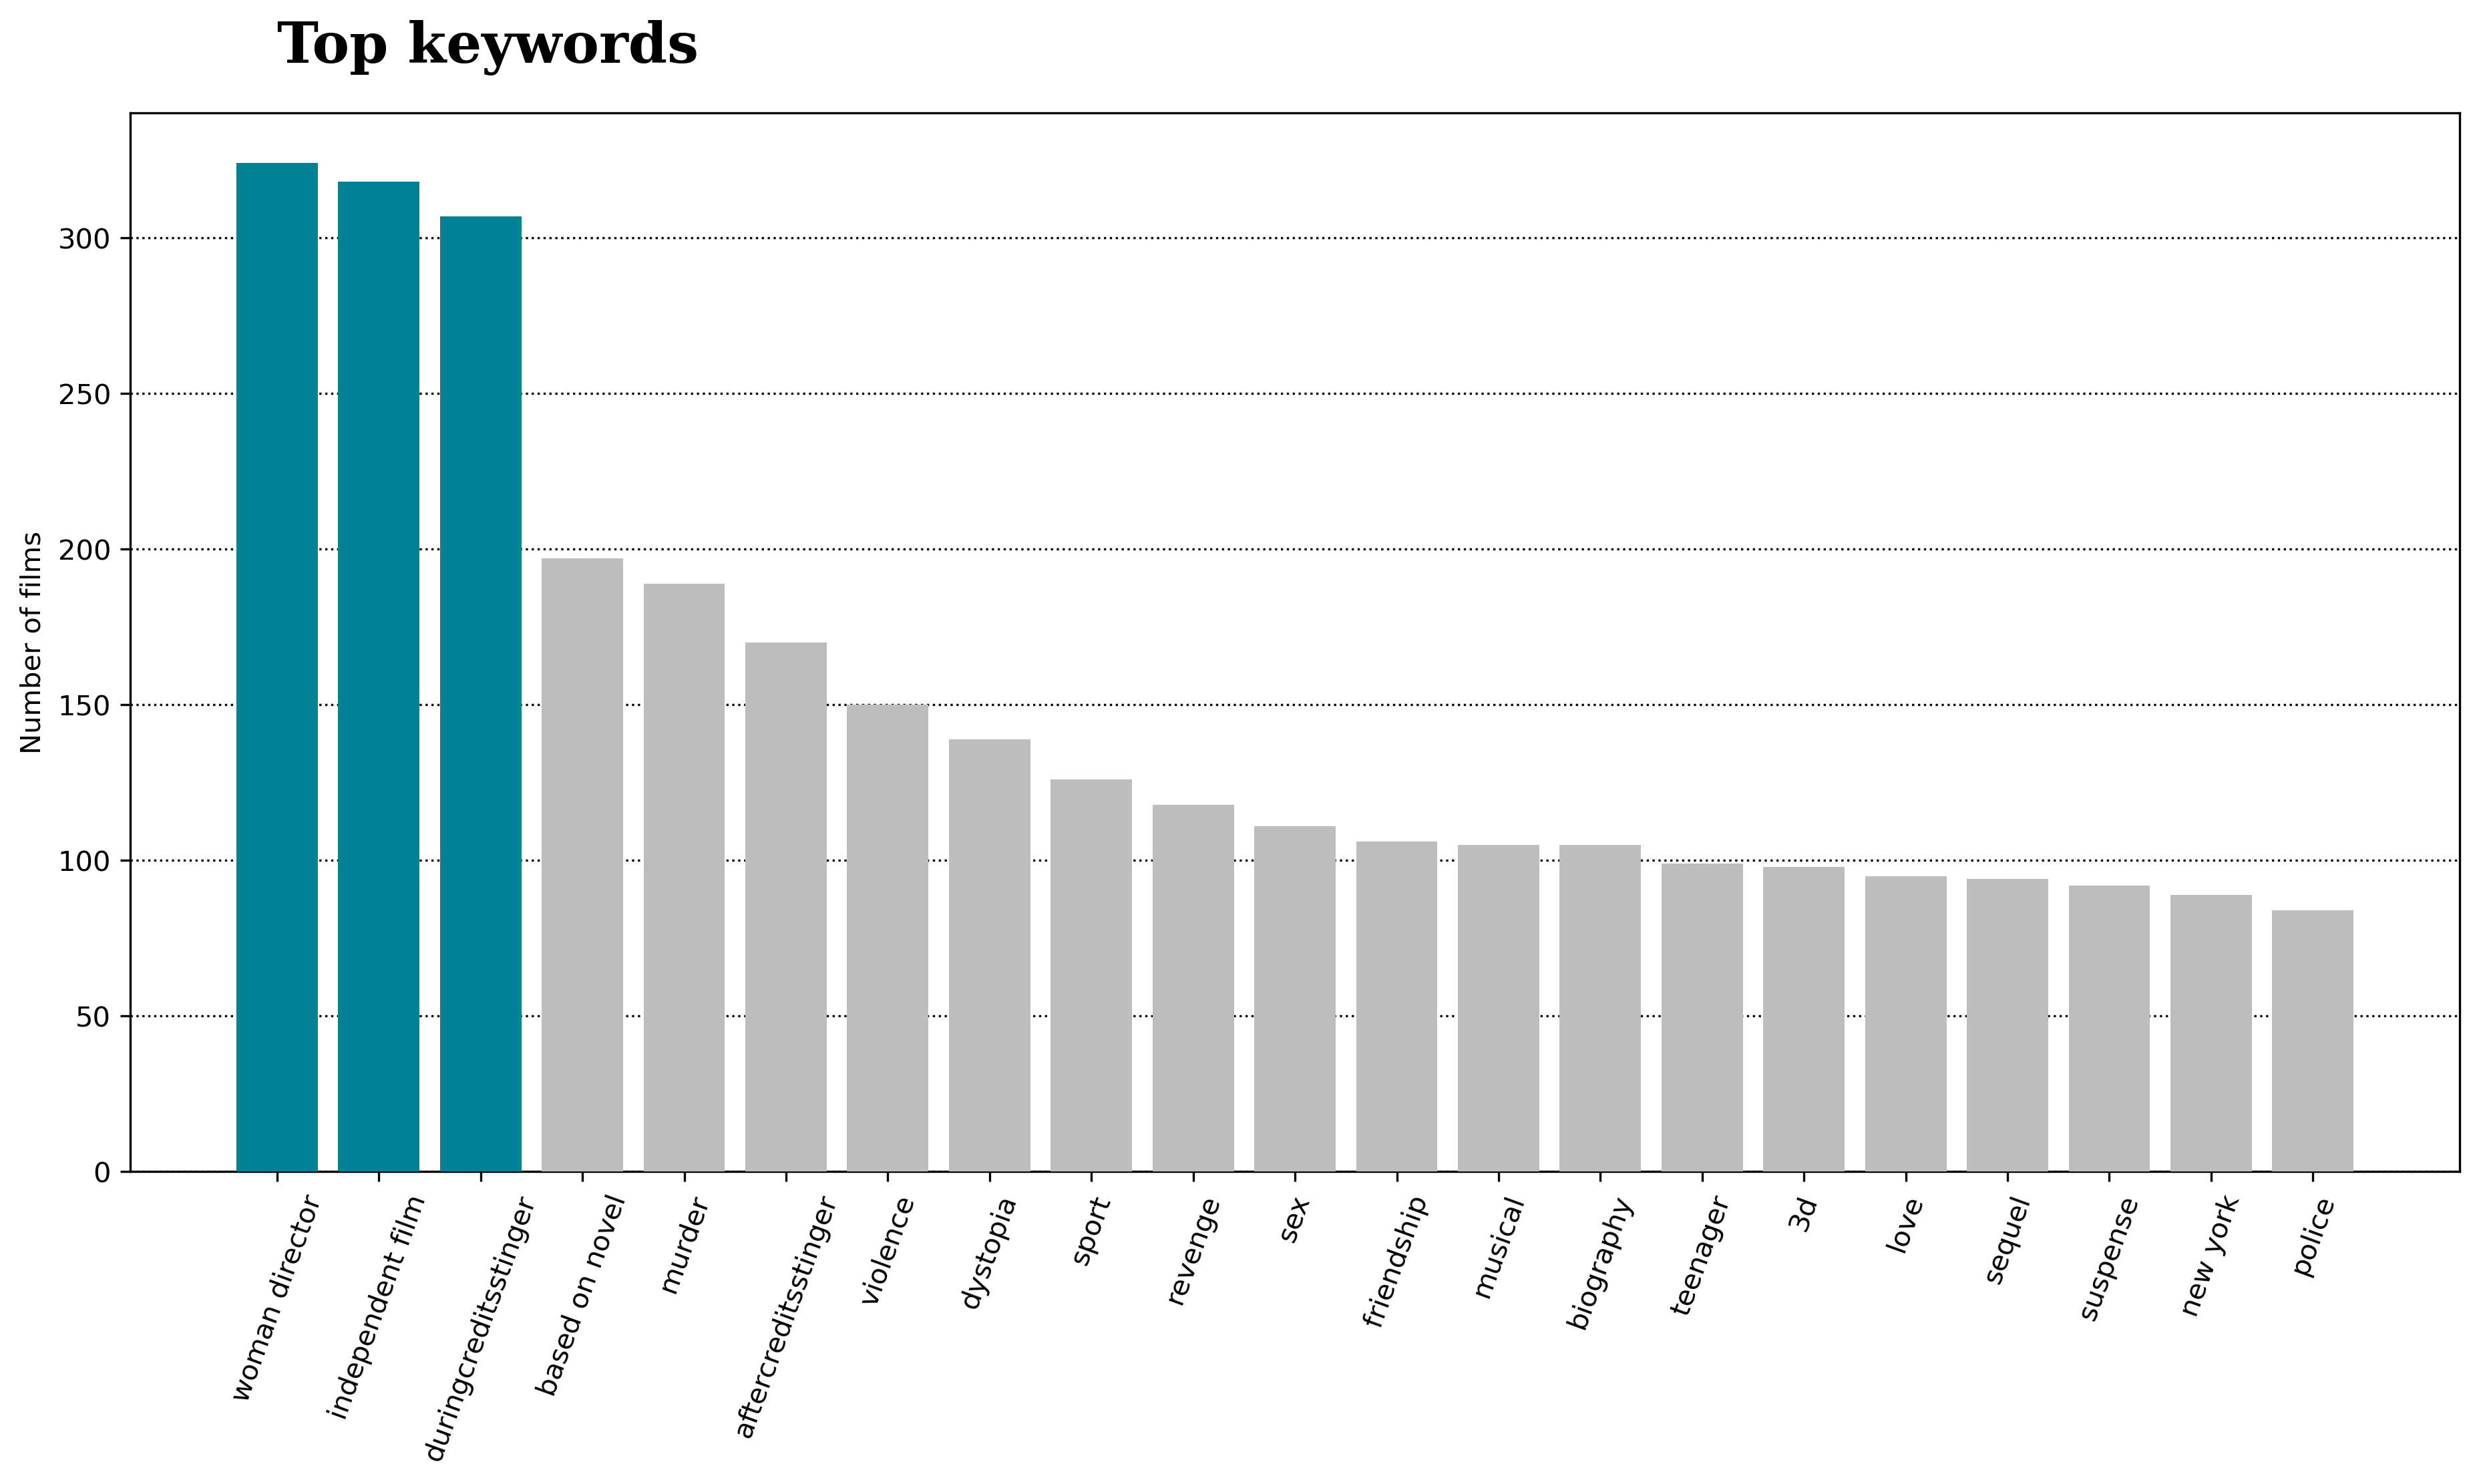

In [13]:
make_raiting_plot(df_movies['keywords'], 'Top keywords', 21)

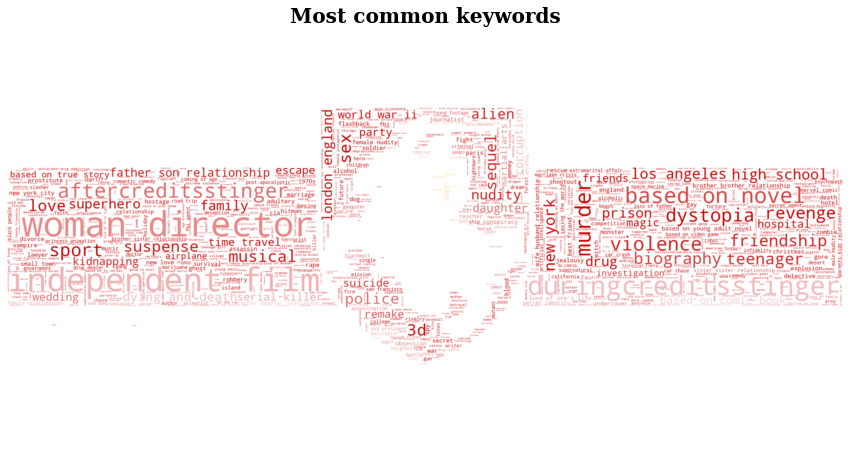

In [171]:
# add all keywords to one list and count them
keywords = []
for words in df_movies.keywords:
    keywords.extend(words)
keywords_freq = Counter(keywords)

# Generate a word cloud image
mask = np.array(Image.open('img/b4b.png'))
wc = WordCloud(max_words=1000, background_color="white", mask=mask)
wc.fit_words(keywords_freq)

# create coloring from image
image_colors = ImageColorGenerator(mask)
fig = plt.figure(figsize=(15,15))
plt.title('Most common keywords', fontsize=20, fontweight='bold', fontfamily='serif')

plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')
plt.savefig('img/common.png', format='png')
plt.show()

## Year of release

In [14]:
df_movies['release_date'] = pd.to_datetime(df_movies.release_date, format='%Y-%m-%d')

In [15]:
years_release = df_movies['release_date'].dt.year\
                                        .dropna()\
                                        .apply(lambda x: int(x//10*10))\
                                        .value_counts()

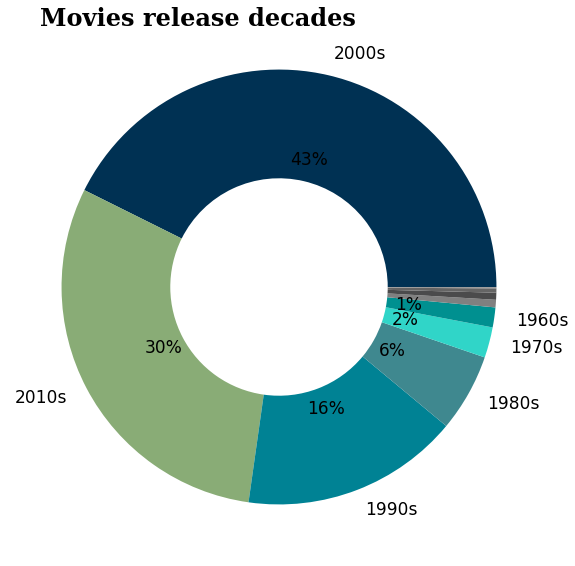

In [16]:
fig = plt.figure(figsize = (10,10))

color_map = ["#003153", "#89ac76","#008294", "#3f888f", "#30d5c8", "#009090", "#808080",
             "#4b4b4c", "#656565", "#808080", "#989898"]
autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else ''
lab = ['' if i<1960 else str(i)+'s' for i in years_release.index]
plt.text(-1.1, 1.2, 'Movies release decades', fontsize=24,
             fontweight='bold', fontfamily='serif')
plt.pie(years_release,autopct=autopct,
        textprops={'fontsize': 17}, wedgeprops= dict(width=0.5),
        labels =lab, colors=color_map)
plt.show()

## Most popular movies

In [61]:
movies = df_movies[['budget', 'popularity', 'original_title', 'vote_average','vote_count']]\
        .sort_values(by='vote_count', ascending=False)\
        .replace(0,np.nan)
movies['budget'] = movies['budget'].apply(lambda x: x/1000000)
movies['genre'] = [ random.choices(i)[0] if len(i)>0 else np.nan for i in df_movies.genres]
movies = movies[movies.vote_count>5]

In [180]:
movies.head()

,budget,popularity,original_title,vote_average,vote_count,genre
96,160.0,167.583710,Inception,8.1,13752.0,Fantasy
65,185.0,187.322927,The Dark Knight,8.2,12002.0,Adventure
0,237.0,150.437577,Avatar,7.2,11800.0,Crime
16,220.0,144.448633,The Avengers,7.4,11776.0,Action
788,58.0,514.569956,Deadpool,7.4,10995.0,Adventure


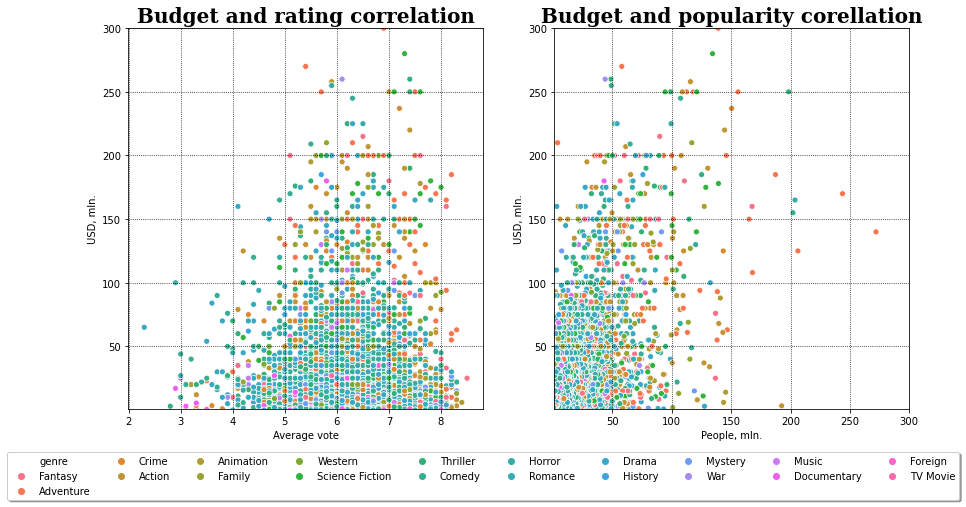

In [224]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

ax[0].set_title('Budget and rating correlation', fontsize=20, fontweight='bold', fontfamily='serif')
sns.scatterplot(y ='budget', x='vote_average', data = movies, hue='genre', ax = ax[0])
ax[0].legend(loc='upper center', bbox_to_anchor=(1, -0.1), fancybox=True, shadow=True, ncol=10)
ax[0].set_xlabel('Average vote')
ax[0].set_ylabel('USD, mln.')
ax[0].set_ylim([1,300])
ax[0].grid(color='black', linestyle=':')

ax[1].set_title('Budget and popularity corellation', fontsize=20, fontweight='bold', fontfamily='serif')
sns.scatterplot(x='popularity', y= 'budget', data=movies, hue='genre', ax=ax[1],legend=None)
ax[1].set_xlabel('People, mln.')
ax[1].set_ylabel('USD, mln.')
ax[1].set_xlim([1,300])
ax[1].set_ylim([1,300])
ax[1].grid(color='black', linestyle=':')
plt.show()



**Using Weighted average values for each movies Average Rating.** 

Formula $(W) = Rv + Cm / v + m$ where,

    Rv = Average for the movie as a number from 0 to 10 (mean) = (Rating)
    Cm = Mean vote count (currently 6.1)
    v = Vote Count for the movies
    m = Minimum votes required to be listed in the top 250 (currently 3000 votes)
    
    

In [228]:
Rv= df_movies['vote_average']
Cm= df_movies['vote_average'].mean()
v= df_movies['vote_count']
m= df_movies['vote_count'].quantile(0.70)

In [231]:
df_movies['weighted_average']

581.0

In [236]:
Cm

6.092171559442011

In [235]:
df_movies['vote_count'].sort_values(ascending=False)[:250]

96      13752
65      12002
0       11800
16      11776
788     10995
        ...  
423      3012
493      3009
1829     3003
2966     2998
717      2998
Name: vote_count, Length: 250, dtype: int64